In [4]:
import gym 
import math
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [5]:
env = gym.make('MountainCarContinuous-v0')
env.seed(101)
np.random.seed(101)

print('observation space:', env.observation_space)
print('action space:', env.action_space)
print('  - low:', env.action_space.low)
print('  - high:', env.action_space.high)

observation space: Box(2,)
action space: Box(1,)
  - low: [-1.]
  - high: [1.]


In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent(nn.Module):
    def __init__(self, env, h_size=16):
        super(Agent, self).__init__()
        self.env = env
        self.s_size = env.observation_space.shape[0]
        self.h_size = h_size
        self.a_size = env.action_space.shape[0]
        self.fc1 = nn.Linear(self.s_size, self.h_size)
        self.fc2 = nn.Linear(self.h_size, self.a_size)

    def set_weights(self, weights):
        fc1_end = (self.s_size * self.h_size) + self.h_size
        fc1_W = torch.from_numpy(weights[:self.s_size * self.h_size].reshape(self.s_size, self.h_size))
        fc1_b = torch.from_numpy(weights[self.s_size * self.h_size : fc1_end])
        fc2_W = torch.from_numpy(weights[fc1_end : fc1_end + (self.h_size * self.a_size)]).reshape(self.h_size, self.a_size)
        fc2_b = torch.from_numpy(weights[fc1_end + (self.h_size * self.a_size) : ])
        self.fc1.weight.data.copy_(fc1_W.view_as(self.fc1.weight.data))
        self.fc1.bias.data.copy_(fc1_b.view_as(self.fc1.bias.data))
        self.fc2.weight.data.copy_(fc2_W.view_as(self.fc2.weight.data))
        self.fc2.bias.data.copy_(fc2_b.view_as(self.fc2.bias.data))

    def get_weights_dim(self):
        return (self.s_size + 1) * self.h_size + (self.h_size+1) * self.a_size

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.tanh(self.fc2(x))
        return x.cpu().data

    def evaluate(self, weights, gamma=1.0, max_t = 5000):
        self.set_weights(weights)
        episode_return = 0.0
        state = self.env.reset()
        for t in range(max_t):
            state = torch.from_numpy(state).float().to(device)
            action = self.forward(state)
            state, reward, done, _ = self.env.step(action)
            episode_return = reward + math.pow(gamma, t)
            if done:
                break
        return episode_return

agent = Agent(env).to(device)


Episode 10	Average Score: 0.95
Episode 20	Average Score: 1.65
Episode 30	Average Score: 6.48
Episode 40	Average Score: 15.15
Episode 50	Average Score: 23.43
Episode 60	Average Score: 27.98
Episode 70	Average Score: 31.46
Episode 80	Average Score: 34.70
Episode 90	Average Score: 38.33
Episode 100	Average Score: 42.07
Episode 110	Average Score: 48.89
Episode 120	Average Score: 55.13
Episode 130	Average Score: 60.51
Episode 140	Average Score: 63.62
Episode 150	Average Score: 64.84
Episode 160	Average Score: 67.22
Episode 170	Average Score: 69.50
Episode 180	Average Score: 70.88
Episode 190	Average Score: 71.87
Episode 200	Average Score: 71.32
Episode 210	Average Score: 71.50
Episode 220	Average Score: 71.36
Episode 230	Average Score: 71.38
Episode 240	Average Score: 72.00
Episode 250	Average Score: 72.02
Episode 260	Average Score: 72.20
Episode 270	Average Score: 72.60
Episode 280	Average Score: 72.76
Episode 290	Average Score: 72.90
Episode 300	Average Score: 73.08
Episode 310	Average Sc

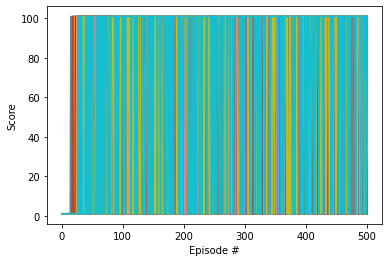

In [4]:
def cem(n_iterations=500, max_t=1000, gamma=1.0, print_every=10, pop_size=50, elite_frac=0.2, sigma=0.5):
    """Params
    ======
        n_iterations (int): maximum number of training iterations
        max_t (int): maximum number of timesteps per episode
        gamma (float): discount rate
        print_every (int): how often to print average score (over last 100 episodes)
        pop_size (int): size of population at each iteration
        elite_frac (float): percentage of top performers to use in update
        sigma (float): standard deviation of additive noise
    """
    n_elite = int(elite_frac * pop_size)

    scores_deque = deque(maxlen=100)
    scores = []
    best_weight = sigma * np.random.randn(agent.get_weights_dim())

    for i_iteration in range(1, n_iterations+1):
        weights_pop = [best_weight + (sigma * np.random.randn(agent.get_weights_dim())) for i in range(pop_size)]
        rewards = np.array([agent.evaluate(weights, gamma, max_t) for weights in weights_pop])

        elite_idxs = rewards.argsort()[-n_elite:]
        elite_weights = [weights_pop[i] for i in elite_idxs]
        best_weight = np.array(elite_weights).mean(axis=0)

        reward = agent.evaluate(best_weight, gamma=1.0)
        scores_deque.append(rewards)
        scores.append(rewards)

        torch.save(agent.state_dict(), 'checkpoint.pth')

        if i_iteration % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_iteration, np.mean(scores_deque)))

        if np.mean(scores_deque)>=90.0:
            print('\nEnvironment solved in {:d} iterations!\tAverage Score: {:.2f}'.format(i_iteration-100, np.mean(scores_deque)))
            break
    return scores

scores = cem()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()


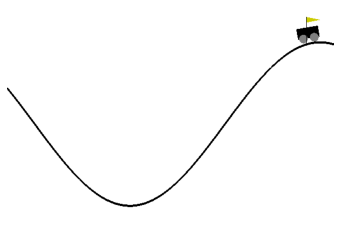

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

agent.load_state_dict(torch.load('checkpoint.pth'))

state = env.reset()
img = plt.imshow(env.render(mode='rgb_array'))
while True:
    state = torch.from_numpy(state).float().to(device)
    with torch.no_grad():
        action = agent(state)
    next_state, reward, done, _ = env.step(action)
    img.set_data(env.render(mode='rgb_array')) 
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)    
    state = next_state
    if done:
        break

env.close()

In [9]:
def cem(n_iterations=500, max_t=1000, gamma=1.0, print_every=10, pop_size=50, elite_frac=0.2, sigma=0.5):
    """Params
    ======
        n_iterations (int): maximum number of training iterations
        max_t (int): maximum number of timesteps per episode
        gamma (float): discount rate
        print_every (int): how often to print average score (over last 100 episodes)
        pop_size (int): size of population at each iteration
        elite_frac (float): percentage of top performers to use in update
        sigma (float): standard deviation of additive noise
    """
    n_elite = int(elite_frac * pop_size)

    scores_deque = deque(maxlen=100)
    scores = []
    best_weight = sigma * np.random.randn(agent.get_weights_dim())
    print(best_weight)

cem()

In [11]:
print(best_weight)

NameError: name 'best_weight' is not defined